# Expression Plots

Gene expression plots per cell state.

1. Seurat object
2. Configs
3. ATAC->RNA labels

In [1]:
library(Seurat)
library(ggplot2)
library(scales)

### Seurat Object

In [3]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")

### Configs

In [4]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

cluster_config

cluster,colour,description,new_cluster
<int>,<chr>,<chr>,<int>
1,#B03743,Fibroblast,1
2,#E85F6D,Fibroblast-like,3
3,#7C2730,Fibroblast-like,2
4,#F0A118,Intermediate,12
5,#78A824,Pre-iPSC,13
6,#A6D854,Pre-iPSC,14
7,#F01D35,Fibroblast-like,5
8,#13C4A3,iPSC,15
9,#406614,Partially-reprogrammed,10


### ATAC-RNA Cluster Transfer

In [5]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/atac.20210717_n62599.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,1,1
AAACCCAAGTGCCAGA-1,D0,1,1
AAACCCACACCATTCC-1,D0,1,1
AAACCCACACGCGTCA-1,D0,1,1
AAACCCAGTCCATAGT-1,D0,1,1
AAACCCAGTTATTCTC-1,D0,1,1


## Plotting

In [9]:
all(colnames(rna) == rownames(atac.rna.label))

[1] TRUE

In [18]:
vals = c()
genes = c()

gene_subset = c('POU5F1','SOX2','KLF4', 'MYC')

for (x in gene_subset) {    
    cur_vals = as.vector(rna[['RNA']][x])
    # min (0) - max (0.99) normalize
    cur_vals = cur_vals - min(cur_vals)
    cur_vals = cur_vals/quantile(cur_vals, .99)
    cur_vals[cur_vals>1] = 1
    
    vals = c(vals, cur_vals)
    genes = c(genes, rep(x, ncol(rna)))
}

all_clusts = paste(cluster_config[atac.rna.label$atac_cluster, "new_cluster"], cluster_config[atac.rna.label$atac_cluster, "description"], sep='\n')

clust_levels = paste(cluster_config$new_cluster, cluster_config$description, sep='\n')[order(cluster_config$new_cluster)]

per_state_df = data.frame(clusters = factor(rep(all_clusts, length(gene_subset)), levels=clust_levels),
                          vals=vals, 
                          genes=factor(genes, levels=gene_subset))

In [21]:
# https://stackoverflow.com/questions/8197559/emulate-ggplot2-default-color-palette
# ggplot default colors
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

In [32]:
cols = gg_color_hue(4)
cols = cols[c(1,2,4)] # switch 3 and 4 to match ChromVAR which has O, S, OS, K motifs. Change MYC to different color.
cols = c(cols, "grey")
cols

[1] "#F8766D" "#7CAE00" "#C77CFF" "grey"

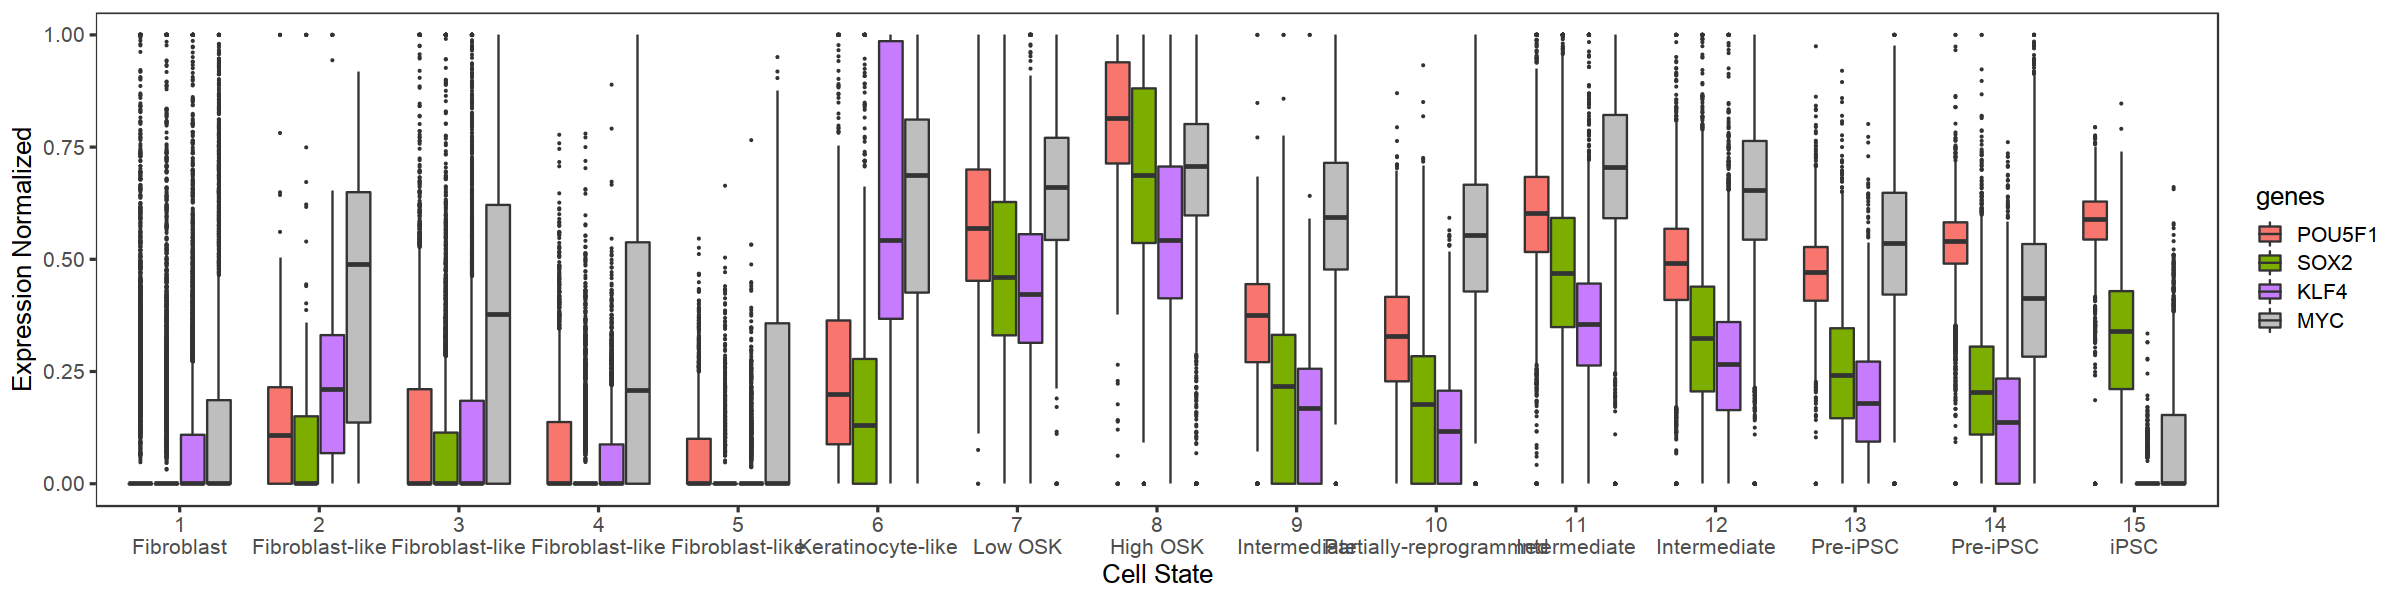

In [34]:
options(repr.plot.width = 20, repr.plot.height = 5)

per_state_expr = ggplot(per_state_df) +
    geom_boxplot(aes(x=clusters, y=vals, fill=genes), outlier.size=0.1) + # for violin: scale='width')  +
    theme_bw(base_size = 15) +
    theme(panel.grid.major=element_blank(),
         panel.grid.minor=element_blank()) +
    ylab("Expression Normalized") +
    xlab("Cell State")  +
scale_fill_manual(values=cols)

per_state_expr

In [35]:
ggsave(per_state_expr, file="./subfigs/per_state_expr.pdf", useDingbats=F, height=5, width=20)